In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

from spacy.tokens import DocBin
import spacy
from tqdm import tqdm
import random

import re

In [2]:
train_data = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
patient_notes = pd.read_csv("patient_notes.csv")

#### PN History

In [3]:
case_5 = patient_notes[patient_notes.case_num== 5]

In [4]:
case_5.head()

,pn_num,case_num,pn_history
20192,50001,5,26 yo F presents for follow up after ED visit ...
20193,50002,5,26 yo F c/o worsening heart palpitations for t...
20194,50003,5,Mrs. Whelan is a 24 yo female that presents fo...
20195,50004,5,26 yo f with episodic heart palpitations. Star...
20196,50005,5,26 YO female with a 5 year history of palpitat...


In [5]:
case_5.head()

,pn_num,case_num,pn_history
20192,50001,5,26 yo F presents for follow up after ED visit ...
20193,50002,5,26 yo F c/o worsening heart palpitations for t...
20194,50003,5,Mrs. Whelan is a 24 yo female that presents fo...
20195,50004,5,26 yo f with episodic heart palpitations. Star...
20196,50005,5,26 YO female with a 5 year history of palpitat...


In [6]:
new_train = train_data.copy()

In [7]:
new_train = new_train[new_train.annotation != '[]']
new_train

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
...,...,...,...,...,...,...
14291,95333_908,9,95333,908,['Nausea'],['354 360']
14293,95333_910,9,95333,910,['lives with roomate'],['576 594']
14297,95333_914,9,95333,914,['photobia'],['274 282']
14298,95333_915,9,95333,915,['no sick contacts'],['421 437']


In [8]:
seperate_data = train_data.copy()

In [9]:
seperate_data = seperate_data[seperate_data.annotation != '[]']
seperate_data.head(3)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']


In [10]:
sep_case5 = seperate_data[seperate_data.case_num == 5]

In [11]:
sep_case5.head()

,id,case_num,pn_num,feature_num,annotation,location
6901,50072_501,5,50072,501,['F'],['22 23']
6903,50072_503,5,50072,503,['assoc SOB'],['298 307']
6904,50072_504,5,50072,504,"['palpitations', 'palpitation event']","['48 60', '401 418']"
6905,50072_505,5,50072,505,['was seen 2 weeks ago for similar symptoms wi...,['120 176']
6906,50072_506,5,50072,506,['No CP'],['426 428;437 439']


In [12]:
case_5_features = features[features["case_num"] == 5]
case_5_features

,feature_num,case_num,feature_text
69,500,5,Onset-5-years-ago
70,501,5,Female
71,502,5,No-caffeine-use
72,503,5,Associated-SOB-OR-Associated-shortness-of-breath
73,504,5,Episodes-of-heart-racing
74,505,5,Recent-visit-to-emergency-department-with-nega...
75,506,5,No-chest-pain
76,507,5,No-illicit-drug-use
77,508,5,Associated-nausea
78,509,5,Increased-frequency-recently


In [13]:
pn_dict = {}
for idx, row in case_5.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [14]:
new_annotation = []
for case_id in case_5_features['case_num'].unique():
    
    all_pn_id = set(case_5[case_5['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_5_features[case_5_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(sep_case5[sep_case5['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = sep_case5[sep_case5['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [15]:
len(new_annotation)

46830

In [16]:
df=pd.DataFrame(new_annotation)

In [17]:
df.head()

,0,1,2,3,4,5
0,50002_500,5,50002,500,[for the past 5 years],[90 110]
1,50003_500,5,50003,500,"[began 5 years ago, 5 years ago]","[132 149, 138 149]"
2,50004_500,5,50004,500,"[5 years ago, Started 5 years ago]","[50 61, 42 61]"
3,50005_500,5,50005,500,"[5 year history, 5 year history of, with a 5 y...","[20 34, 20 37, 13 34]"
4,50006_500,5,50006,500,"[5 years ago, over past 5 years]","[402 413, 441 458]"


In [18]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']

In [19]:
df

,id,case_num,pn_num,feature_num,annotation,location
0,50002_500,5,50002,500,[for the past 5 years],[90 110]
1,50003_500,5,50003,500,"[began 5 years ago, 5 years ago]","[132 149, 138 149]"
2,50004_500,5,50004,500,"[5 years ago, Started 5 years ago]","[50 61, 42 61]"
3,50005_500,5,50005,500,"[5 year history, 5 year history of, with a 5 y...","[20 34, 20 37, 13 34]"
4,50006_500,5,50006,500,"[5 years ago, over past 5 years]","[402 413, 441 458]"
...,...,...,...,...,...,...
46825,57088_517,5,57088,517,"[26 y, 26, 26 y/o]","[13 17, 13 15, 13 19]"
46826,57089_517,5,57089,517,"[26 y, 26 yo, 26]","[7 11, 7 12, 7 9]"
46827,57090_517,5,57090,517,"[26 y, 26, 26 year old, 26 year]","[16 20, 16 18, 16 27, 16 23]"
46828,57091_517,5,57091,517,"[26 y, 26, 26 year old, 26 year]","[0 4, 0 2, 0 11, 0 7]"


In [20]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

In [21]:
df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df

,id,case_num,pn_num,feature_num,annotation,location
0,50002_500,5,50002,500,'for the past 5 years','90 110'
1,50003_500,5,50003,500,"'began 5 years ago', '5 years ago'","'132 149', '138 149'"
2,50004_500,5,50004,500,"'5 years ago', 'Started 5 years ago'","'50 61', '42 61'"
3,50005_500,5,50005,500,"'5 year history', '5 year history of', 'with a...","'20 34', '20 37', '13 34'"
4,50006_500,5,50006,500,"'5 years ago', 'over past 5 years'","'402 413', '441 458'"
...,...,...,...,...,...,...
46825,57088_517,5,57088,517,"'26 y', '26', '26 y/o'","'13 17', '13 15', '13 19'"
46826,57089_517,5,57089,517,"'26 y', '26 yo', '26'","'7 11', '7 12', '7 9'"
46827,57090_517,5,57090,517,"'26 y', '26', '26 year old', '26 year'","'16 20', '16 18', '16 27', '16 23'"
46828,57091_517,5,57091,517,"'26 y', '26', '26 year old', '26 year'","'0 4', '0 2', '0 11', '0 7'"


In [22]:
df = df[['pn_num','annotation',"location","feature_num"]]
df

,pn_num,annotation,location,feature_num
0,50002,'for the past 5 years','90 110',500
1,50003,"'began 5 years ago', '5 years ago'","'132 149', '138 149'",500
2,50004,"'5 years ago', 'Started 5 years ago'","'50 61', '42 61'",500
3,50005,"'5 year history', '5 year history of', 'with a...","'20 34', '20 37', '13 34'",500
4,50006,"'5 years ago', 'over past 5 years'","'402 413', '441 458'",500
...,...,...,...,...
46825,57088,"'26 y', '26', '26 y/o'","'13 17', '13 15', '13 19'",517
46826,57089,"'26 y', '26 yo', '26'","'7 11', '7 12', '7 9'",517
46827,57090,"'26 y', '26', '26 year old', '26 year'","'16 20', '16 18', '16 27', '16 23'",517
46828,57091,"'26 y', '26', '26 year old', '26 year'","'0 4', '0 2', '0 11', '0 7'",517


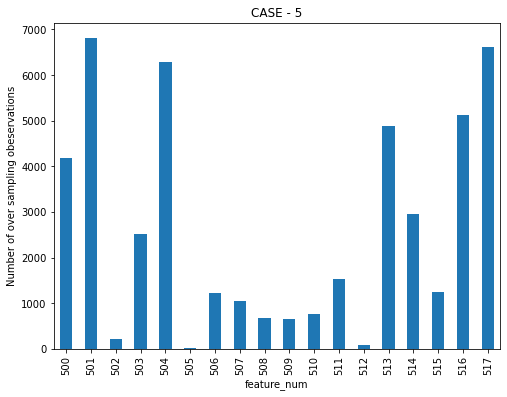

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
df.groupby("feature_num").size().plot.bar()
plt.title("CASE - 5")
plt.ylabel("Number of over sampling obeservations")
plt.show()

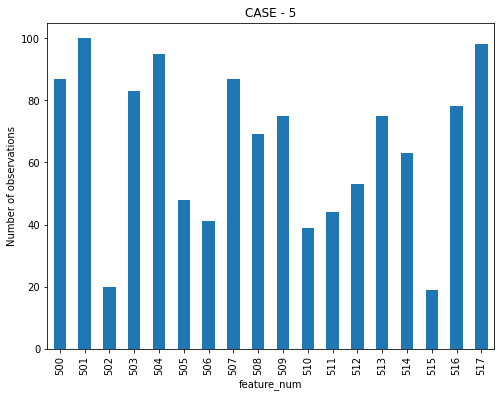

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
sep_case5.groupby("feature_num").size().plot.bar()
plt.title("CASE - 5")
plt.ylabel("Number of observations")
plt.show()

In [25]:
sep_case5["annotation"] = sep_case5.annotation.str.replace('[','')
sep_case5["annotation"] = sep_case5.annotation.str.replace(']','')
sep_case5["location"] = sep_case5.location.str.replace('[','')
sep_case5["location"] = sep_case5.location.str.replace(']','')

sep_case5

,id,case_num,pn_num,feature_num,annotation,location
6901,50072_501,5,50072,501,'F','22 23'
6903,50072_503,5,50072,503,'assoc SOB','298 307'
6904,50072_504,5,50072,504,"'palpitations', 'palpitation event'","'48 60', '401 418'"
6905,50072_505,5,50072,505,'was seen 2 weeks ago for similar symptoms wit...,'120 176'
6906,50072_506,5,50072,506,'No CP','426 428;437 439'
...,...,...,...,...,...,...
8692,57026_510,5,57026,510,'During these episodes she has fear taht somet...,'447 519'
8693,57026_511,5,57026,511,'lasts about 15 to 30 minutes','286 314'
8694,57026_512,5,57026,512,'associated with feels like her throat his tig...,'323 338;407 445'
8695,57026_513,5,57026,513,"'feeling hot', 'clammy'","'339 350', '365 371'"


#### case 0 data

In [26]:
sep_case5 = sep_case5.drop(["id"],axis= 1)

In [27]:
sep_case5 = (sep_case5.set_index(['pn_num',"feature_num","case_num"]) 
  .apply(lambda col: col.str.split("',").explode())
   .reset_index()
   .reindex(sep_case5.columns, axis=1))

In [28]:
sep_case5["location"] = sep_case5["location"].apply(lambda x: x+"'" if "'" != x[-1] else x)

In [29]:
df_502 = df[df["feature_num"] == 502].sample(n = 80, random_state = 100)
df_502.shape

(80, 4)

In [30]:
df_505 = df[df["feature_num"] == 505]
df_505.shape

(13, 4)

In [31]:
df_506 = df[df["feature_num"] == 506].sample(n = 60, random_state = 100)
df_506.shape

(60, 4)

In [32]:
df_510 = df[df["feature_num"] == 510].sample(n = 60, random_state = 100)
df_510.shape

(60, 4)

In [33]:
df_511 = df[df["feature_num"] == 511].sample(n = 60, random_state = 100)
df_511.shape

(60, 4)

In [34]:
df_512 = df[df["feature_num"] == 512]
df_512.shape

(74, 4)

In [35]:
df_515 = df[df["feature_num"] == 515].sample(n = 80, random_state = 100)
df_515.shape

(80, 4)

In [36]:
df.head()

,pn_num,annotation,location,feature_num
0,50002,'for the past 5 years','90 110',500
1,50003,"'began 5 years ago', '5 years ago'","'132 149', '138 149'",500
2,50004,"'5 years ago', 'Started 5 years ago'","'50 61', '42 61'",500
3,50005,"'5 year history', '5 year history of', 'with a...","'20 34', '20 37', '13 34'",500
4,50006,"'5 years ago', 'over past 5 years'","'402 413', '441 458'",500


In [37]:
sep_case5.head()

,case_num,pn_num,feature_num,annotation,location
0,5,50072,501,'F','22 23'
1,5,50072,503,'assoc SOB','298 307'
2,5,50072,504,'palpitations,'48 60'
3,5,50072,504,'palpitation event','401 418'
4,5,50072,505,'was seen 2 weeks ago for similar symptoms wit...,'120 176'


In [38]:
case_5_over = pd.concat([sep_case5, df_502, df_505, df_506, df_510, df_511, df_512, df_515])
case_5_over.shape

(1876, 5)

#### Seperating start location and end location

In [39]:
case_5_over["start_location"] = case_5_over["location"].apply(lambda x: x.split()[0][1:])

In [40]:
case_5_over["end_location"] = case_5_over["location"].apply(lambda x: x.split()[-1][:-1])

#### Combinig Datasets

In [41]:
sep_combined_case5 = pd.merge(case_5_over,patient_notes,on="pn_num")

In [42]:
sep_combined_case5 = sep_combined_case5.drop("case_num_x",axis = 1)

In [43]:
sep_combined_case5.head()

,pn_num,feature_num,annotation,location,start_location,end_location,case_num_y,pn_history
0,50072,501,'F','22 23',22,23,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...
1,50072,503,'assoc SOB','298 307',298,307,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...
2,50072,504,'palpitations,'48 60',48,60,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...
3,50072,504,'palpitation event','401 418',401,418,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...
4,50072,505,'was seen 2 weeks ago for similar symptoms wit...,'120 176',120,176,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...


In [44]:
sep_combined_case5["New_annotation"] = sep_combined_case5.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)

In [45]:
sep_combined_case5.head()

,pn_num,feature_num,annotation,location,start_location,end_location,case_num_y,pn_history,New_annotation
0,50072,501,'F','22 23',22,23,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,F
1,50072,503,'assoc SOB','298 307',298,307,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,assoc SOB
2,50072,504,'palpitations,'48 60',48,60,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitations
3,50072,504,'palpitation event','401 418',401,418,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitation event
4,50072,505,'was seen 2 weeks ago for similar symptoms wit...,'120 176',120,176,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,was seen 2 weeks ago for similar symptoms with...


In [46]:
sep_combined_case5["New_annotation"] = sep_combined_case5["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
sep_combined_case5["New_annotation"] = sep_combined_case5["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
sep_combined_case5["New_annotation"] = sep_combined_case5["New_annotation"].apply(lambda x: x.strip())
sep_combined_case5["pn_history"] = sep_combined_case5["pn_history"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
sep_combined_case5["pn_history"] = sep_combined_case5["pn_history"].apply(lambda x: x.strip())
sep_combined_case5.head(10)

,pn_num,feature_num,annotation,location,start_location,end_location,case_num_y,pn_history,New_annotation
0,50072,501,'F','22 23',22,23,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,F
1,50072,503,'assoc SOB','298 307',298,307,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,assoc SOB
2,50072,504,'palpitations,'48 60',48,60,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitations
3,50072,504,'palpitation event','401 418',401,418,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitation event
4,50072,505,'was seen 2 weeks ago for similar symptoms wit...,'120 176',120,176,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,was seen 2 weeks ago for similar symptoms with...
5,50072,506,'No CP','426 428;437 439',426,439,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,No dyspne CP
6,50072,507,'No drug use','721 723;744 752',721,752,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,No alcohol tobacco or drug use
7,50072,509,'increasing in freq in the past 2 weeks','76 114',76,114,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,increasing in freq in the past 2 weeks
8,50072,511,'last 12-30 min','192 206',192,206,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,last 12-30 min
9,50072,513,'clamy','331 336',331,336,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,clamy


#### Dropping these rows as there are spelling mistakes due to which unable to find the locations

In [47]:
#sep_combined_case0["pn_history"] = sep_combined_case0["pn_history"].apply(lambda x: re.sub(r'''[/",()\r\n]''',' ',x))
#sep_combined_case0["pn_history"] = sep_combined_case0["pn_history"].apply(lambda x: re.sub(r'''[']''','',x))

In [48]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [49]:
sep_combined_case5["New_annotation"] = sep_combined_case5["New_annotation"].apply(word_lemm)
sep_combined_case5["pn_history"] = sep_combined_case5["pn_history"].apply(word_lemm)
sep_combined_case5.head()

,pn_num,feature_num,annotation,location,start_location,end_location,case_num_y,pn_history,New_annotation
0,50072,501,'F','22 23',22,23,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,F
1,50072,503,'assoc SOB','298 307',298,307,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,assoc SOB
2,50072,504,'palpitations,'48 60',48,60,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitation
3,50072,504,'palpitation event','401 418',401,418,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitation event
4,50072,505,'was seen 2 weeks ago for similar symptoms wit...,'120 176',120,176,5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,wa seen 2 week ago for similar symptom with a ...


In [50]:
sep_combined_case5.iloc[1273,]

pn_num                                                        55853
feature_num                                                     516
annotation                                           '+ life stress
location                                                  '363 376'
start_location                                                  363
end_location                                                    376
case_num_y                                                        5
pn_history        26 yo female w unremarkable PMHx c o heart pal...
New_annotation                                          life stress
Name: 1273, dtype: object

In [51]:
sep_combined_case5["new_location"] = sep_combined_case5.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.pn_history),axis =1)

In [52]:
i = 0
for location in sep_combined_case5["new_location"]:
    if location == None:
        i+= 1
        
print(i)

38


In [53]:
drop_index = []
for  index,row in sep_combined_case5.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
print(drop_index)

[91, 113, 119, 121, 153, 160, 161, 257, 297, 319, 329, 446, 470, 476, 479, 480, 497, 653, 881, 965, 971, 1043, 1061, 1304, 1319, 1534, 1644, 1676, 1699, 1711, 1769, 1815, 1826, 1828, 1832, 1838, 1844, 1875]


In [54]:
sep_combined_case5 = sep_combined_case5.drop(drop_index,axis = 0)

In [55]:
sep_combined_case5["new_location"] = sep_combined_case5.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.pn_history).span(),axis =1)

In [56]:
sep_combined_case5  = sep_combined_case5.drop(['annotation', 'start_location','end_location'],axis = 1)

In [57]:
sep_combined_case5["start_location"] = sep_combined_case5.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.pn_history).start(),axis =1)
sep_combined_case5["end_location"] = sep_combined_case5.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.pn_history).end(),axis =1)

In [58]:
sep_combined_case5.head()

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
0,50072,501,'22 23',5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,F,"(22, 23)",22,23
1,50072,503,'298 307',5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,assoc SOB,"(287, 296)",287,296
2,50072,504,'48 60',5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitation,"(48, 59)",48,59
3,50072,504,'401 418',5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,palpitation event,"(386, 403)",386,403
4,50072,505,'120 176',5,Ms. Whelan is a 26 yo F with a 6 mo hx of hear...,wa seen 2 week ago for similar symptom with a ...,"(119, 172)",119,172


sep_combined_case5 = sep_combined_case5.drop([1427, 1423, 1420],axis=0)
sep_combined_case5 = sep_combined_case5.drop(1440,axis=0)
sep_combined_case5 = sep_combined_case5.drop(1438,axis=0)
sep_combined_case5 = sep_combined_case5.drop(1441,axis=0)
sep_combined_case5 = sep_combined_case5.drop(1445,axis=0)
row_index = []
start_location = []
end_location = []
pn_notes = set()
drop_index = []
for index,row in sep_combined_case5.iterrows():   # Iterating every row in trainn data
    if row["pn_num"] not in pn_notes:    # Verifying whether there is a change in pn_num to reinitialize start and end location lists
        start_location = []
        end_location = []
        pn_notes.add(row["pn_num"])      # Appending pn_num
        if (row["start_location"] in start_location) | (row["end_location"] in end_location):
            row_index.append(index)
        start_location.append(row["start_location"])
        end_location.append(row["end_location"])
    else: 

        if (row["start_location"] in start_location) | (row["end_location"] in end_location):
            row_index.append(index)
            
            if row["start_location"] in start_location:
                if row["end_location"] >= sep_combined_case5.iloc[index -1 ,8]:
                    drop_index.append(index -1)
                else:
                    drop_index.append(index)
            elif row["end_location"] in end_location:
                if row["start_location"] <= sep_combined_case5.iloc[index -1,7]:
                    drop_index.append(index - 1)
                else:
                    drop_index.append(index)
        start_location.append(row["start_location"])
        end_location.append(row["end_location"])
print(drop_index)  
len(drop_index)
# first index
sep_combined_case5 = sep_combined_case5.drop(index=drop_index)

### Feature wise model training

In [59]:
np.sort(sep_combined_case5.feature_num.unique())

array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517], dtype=int64)

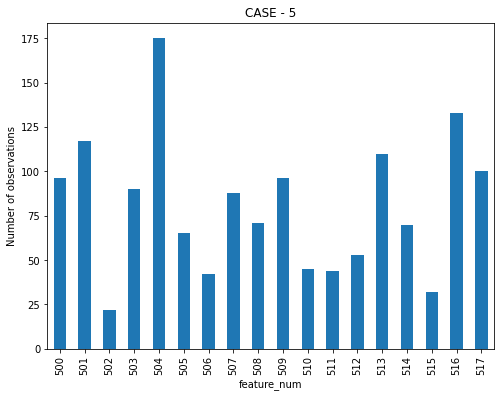

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
sep_case5.groupby("feature_num").size().plot.bar()
plt.title("CASE - 5")
plt.ylabel("Number of observations")
plt.show()

### Feature 500

In [61]:
sep_combined_case5_500 = sep_combined_case5[sep_combined_case5.feature_num == 500]

#### Dropping Overlapping rows

In [62]:
drop_500 = [266,557,659,932,1091]

In [63]:
sep_combined_case5_500 = sep_combined_case5_500.drop(drop_500)

In [64]:
sep_combined_case5_500[(sep_combined_case5_500.end_location ==285) | (sep_combined_case5_500.end_location == 285)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
660,53161,500,'272 275;285 292',5,The patient is a 26 year old female presnting ...,for the last 5 year,"(266, 285)",266,285


In [65]:
sep_combined_case5_500[(sep_combined_case5_500.end_location ==170)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1092,55060,500,'144 176',5,26 F present for follow up for episode of palp...,first experienced this 5 yr ago,"(139, 170)",139,170


In [66]:
pn_Num_list = list(sep_combined_case5_500.pn_num.unique())

In [67]:
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_500[sep_combined_case5_500.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_500[sep_combined_case5_500.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [68]:
final_train

[("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very cold and clammy . She also becomes nauseous and can become very fatigued afterwards . Her finger also went numb with the attack 2 week ago . Pt doe state she 's under a lot of stress a she recently bought a condo and just lost her job 2 mo . ago . She ha been noticing these attack for about 5 year . ROS for SOB chest tightness sense of doom stress anxiety nausea flushing poor concentration denies sweating diarrhea vomiting dizziness headache or weight loss or gain or brittle skin hair No allergy med PMHx SHx FMHx or OB Hx . Lives alone in a condo is a non-smoker non-drinker and no illicit drug use .",
  {'entities': [(481, 519, 'Feature_500')]}),
 ('Edie Whelan is a 26 year old female who present a follow up from the ED for palpitation . She ha been having episode w

In [69]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_500.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_500.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [70]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_500.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 225.57it/s]


In [71]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_500.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 320.88it/s]


In [72]:
!python -m spacy init fill-config ./base_config_500.cfg ./config_500.cfg

[+] Auto-filled config with all values
[+] Saved config
config_500.cfg
You can now add your data and train your pipeline:
python -m spacy train config_500.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 13:43:10.852326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 13:43:10.852386: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [73]:
!python -m spacy train config_500.cfg --output ./output_500

[+] Created output directory: output_500
[i] Saving to output directory: output_500
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     52.83    0.00    0.00    0.00    0.00
  2     200       3824.42   2835.63   23.53   26.67   21.05    0.24
  5     400       1099.49    207.91   16.67   17.65   15.79    0.17
  8     600         59.63     67.02   24.24   28.57   21.05    0.24
 11     800         59.24     66.73   28.57   31.25   26.32    0.29
 14    1000        182.12     49.45   35.29   40.00   31.58    0.35
 17    1200         53.07     38.31   29.41   33.33   26.32    0.29
 20    1400      10547.18     69.09   38.89 

2022-05-01 13:43:18.080655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 13:43:18.080944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 13:43:23,320] [INFO] Set up nlp object from config
[2022-05-01 13:43:23,331] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 13:43:23,336] [INFO] Created vocabulary
[2022-05-01 13:43:23,339] [INFO] Finished initializing nlp object
[2022-05-01 13:43:23,891] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 501

In [74]:
sep_combined_case5_501 = sep_combined_case5[sep_combined_case5.feature_num == 501]

#### Dropping Overlapping rows

In [75]:
drop_501 = [269,935,1094]

In [76]:
sep_combined_case5_501 = sep_combined_case5_501.drop(drop_501)

In [77]:
sep_combined_case5_501[(sep_combined_case5_501.end_location == 13)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
43,50535,501,'12 13',5,HPI : 26 YO F C O EPISODES OF PALPITATIONS THA...,F,"(12, 13)",12,13
53,50541,501,'12 13',5,Pt is 26 yo F presenting w c o palpitation and...,F,"(12, 13)",12,13
72,50571,501,'7 13',5,26 y o female w o pertinent PMH who present to...,female,"(7, 13)",7,13
593,53035,501,'8 12',5,HPI : 26 YO F C O SUDDEN ONSET OF POUNDING HEA...,YO F,"(9, 13)",9,13
934,54517,501,'11 12',5,HPI : 26 yo F c o palpitation X5 year with inc...,F,"(12, 13)",12,13


In [78]:
sep_combined_case5_501[(sep_combined_case5_501.end_location ==4) | (sep_combined_case5_501.end_location == 4)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
832,54222,501,'3 4',5,26 f come to the clinic with co racing of hear...,f,"(3, 4)",3,4
1093,55060,501,'3 4',5,26 F present for follow up for episode of palp...,F,"(3, 4)",3,4


In [79]:
pn_Num_list = list(sep_combined_case5_501.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_501[sep_combined_case5_501.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_501[sep_combined_case5_501.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [80]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(22, 23, 'Feature_501')]}),
 ("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very c

In [81]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_501.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_501.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [82]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_501.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 273.38it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [83]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_501.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 305.72it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [84]:
!python -m spacy init fill-config ./base_config_501.cfg ./config_501.cfg

[+] Auto-filled config with all values
[+] Saved config
config_501.cfg
You can now add your data and train your pipeline:
python -m spacy train config_501.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 13:52:12.278916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 13:52:12.278968: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [85]:
!python -m spacy train config_501.cfg --output ./output_501

[+] Created output directory: output_501
[i] Saving to output directory: output_501
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     59.00    0.00    0.00    0.00    0.00
  2     200         11.01   1037.92   97.56  100.00   95.24    0.98
  5     400          7.54     25.43   97.56  100.00   95.24    0.98
  7     600          4.69     17.47   97.56  100.00   95.24    0.98
 10     800         12.02     22.55   97.56  100.00   95.24    0.98
 13    1000          6.57     19.03   87.80   90.00   85.71    0.88
 15    1200          7.50     16.19   97.56  100.00   95.24    0.98
 18    1400          3.50     14.21   95.24 

2022-05-01 13:52:20.005394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 13:52:20.005452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 13:52:24,565] [INFO] Set up nlp object from config
[2022-05-01 13:52:24,572] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 13:52:24,575] [INFO] Created vocabulary
[2022-05-01 13:52:24,575] [INFO] Finished initializing nlp object
[2022-05-01 13:52:24,956] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



output_501\model-last


## Feature 502

In [86]:
sep_combined_case5_502 = sep_combined_case5[sep_combined_case5.feature_num == 502]

#### Dropping Overlapping rows

In [87]:
drop_502= [370]

In [88]:
sep_combined_case5_502 = sep_combined_case5_502.drop(drop_502)

In [89]:
sep_combined_case5_502[(sep_combined_case5_502.end_location == 13)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [90]:
sep_combined_case5_502[(sep_combined_case5_502.end_location == 375)|(sep_combined_case5_502.end_location == 379)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
371,52317,502,'369 371;379 391',5,26 y f presented with palpitation since 3 week...,no excess caffeine use,"(357, 379)",357,379


In [91]:
pn_Num_list = list(sep_combined_case5_502.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_502[sep_combined_case5_502.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_502[sep_combined_case5_502.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [92]:
final_train

[('Edie Whelan is a 26 year old female who present a follow up from the ED for palpitation . She ha been having episode where she will notice her heart pounding and feel hot cold and have clammy hand . She wa seen in the ED 2 week ago with normal CBC metabolic panel troponins and ECG . This happened 5 year ago and stopped and recently started again 3 week ago . She ha been under a lot of stress a she just bought a condo and lost her job 2 month ago . This last episode she did notice tingling in her finger . This will come on sporatically . She will also get nauseous during the episode . ROS : negative execpt for above PMH past surgery : none Medications : none Allergies : none Family history : non contributory . Social history : life alone in a condo . Denies alcohol tobacco durg use and travel . Is sexually active with boyfriend and they use condom . She walk a couple time a week for exercise and doe not drink coffee .',
  {'entities': [(908, 928, 'Feature_502')]}),
 ('Pt is 26 yo F p

In [93]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_502.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_502.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [94]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_502.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 314.03it/s]


In [95]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_502.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 248.21it/s]


In [96]:
!python -m spacy init fill-config ./base_config_502.cfg ./config_502.cfg

[+] Auto-filled config with all values
[+] Saved config
config_502.cfg
You can now add your data and train your pipeline:
python -m spacy train config_502.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 13:57:20.214742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 13:57:20.214828: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [97]:
!python -m spacy train config_502.cfg --output ./output_502

[+] Created output directory: output_502
[i] Saving to output directory: output_502
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     54.67    0.00    0.00    0.00    0.00
  2     200       1031.02   1748.33   78.43   64.52  100.00    0.78
  5     400         57.34    101.32   88.89   80.00  100.00    0.89
  7     600         31.77     51.57   97.56   95.24  100.00    0.98
 10     800         47.63     24.84   83.33   71.43  100.00    0.83
 12    1000         21.36     12.65   93.02   86.96  100.00    0.93
 15    1200         41.04     27.76   93.02   86.96  100.00    0.93
 17    1400          8.02      4.43   88.89 

2022-05-01 13:57:27.277157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 13:57:27.277194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 13:57:31,106] [INFO] Set up nlp object from config
[2022-05-01 13:57:31,114] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 13:57:31,117] [INFO] Created vocabulary
[2022-05-01 13:57:31,117] [INFO] Finished initializing nlp object
[2022-05-01 13:57:31,564] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 503

In [98]:
sep_combined_case5_503 = sep_combined_case5[sep_combined_case5.feature_num == 503]

#### Dropping Overlapping rows

In [99]:
drop_503 = [271,488,937,1045,1079,1096]

In [100]:
sep_combined_case5_503 = sep_combined_case5_503.drop(drop_503)

In [101]:
sep_combined_case5_503[(sep_combined_case5_503.end_location == 152)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
938,54517,503,'136 151;152 155',5,HPI : 26 yo F c o palpitation X5 year with inc...,associated with SOB,"(133, 152)",133,152


In [102]:
sep_combined_case5_503[(sep_combined_case5_503.end_location == 74)|(sep_combined_case5_503.end_location == 74)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1095,55060,503,'58 77',5,26 F present for follow up for episode of palp...,shortness of breath,"(55, 74)",55,74


In [103]:
pn_Num_list = list(sep_combined_case5_503.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_503[sep_combined_case5_503.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_503[sep_combined_case5_503.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [104]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(287, 296, 'Feature_503')]}),
 ('HPI : 26 YO F C O EPISODES OF PALPITATIONS THAT STARTED 5 Y AGO BUT HAS BEEN MORE FREQUENT OVER THE LAST 2 WEEKS . THE EPISODES LAST FOR 15-30 MINUTES EACH AND RESOLVE SPONTANEOUSLY . NO SPECIFIC TRIGGERS OR ALLEVIATING 

In [105]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_503.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_503.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [106]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_503.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 235.88it/s]


In [107]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_503.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 322.48it/s]


In [108]:
!python -m spacy init fill-config ./base_config_503.cfg ./config_503.cfg

[+] Auto-filled config with all values
[+] Saved config
config_503.cfg
You can now add your data and train your pipeline:
python -m spacy train config_503.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 14:03:34.552489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 14:03:34.552543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [109]:
!python -m spacy train config_503.cfg --output ./output_503

2022-05-01 14:03:40.533519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 14:03:40.533559: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 14:03:44,163] [INFO] Set up nlp object from config
[2022-05-01 14:03:44,172] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 14:03:44,175] [INFO] Created vocabulary
[2022-05-01 14:03:44,176] [INFO] Finished initializing nlp object
[2022-05-01 14:03:44,541] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


[+] Created output directory: output_503
[i] Saving to output directory: output_503
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     62.83    0.00    0.00    0.00    0.00
  3     200       1360.98   2122.02   30.00  100.00   17.65    0.30
  6     400         63.48    189.82   30.77   44.44   23.53    0.31
  9     600         51.05     82.68   38.46   55.56   29.41    0.38
 12     800         73.11     69.69   25.81   28.57   23.53    0.26
 15    1000         94.26     39.75   27.59   33.33   23.53    0.28
 18    1200       3300.21     68.74   25.81   28.57   23.53    0.26
 21    1400         33.86     17.92   26.67 

## Feature 504

In [110]:
sep_combined_case5_504 = sep_combined_case5[sep_combined_case5.feature_num == 504]

#### Dropping Overlapping rows

In [111]:
drop_504 = [58,98,99,124,139,154,155,156,185,201,273,291,292,351,352,1191,1378,372,429,432,440,452,471,491,535,550,551,562,577,605,630,711,741,819,861,877,878,941,966,1030,1098,1081,1126,1175,1176,1252,1279,1291,1323,1341,1439]

In [112]:
sep_combined_case5_504 = sep_combined_case5_504.drop(drop_504,axis=0)

In [113]:
sep_combined_case5_504[(sep_combined_case5_504.end_location == 91)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1438,57026,504,'82 94',5,26 year oild female with no PMH who present wi...,palpitation,"(80, 91)",80,91


In [114]:
sep_combined_case5_504[(sep_combined_case5_504.end_location == 29)|(sep_combined_case5_504.end_location == 106)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
803,54207,504,'44 56',5,26 yo female with palpitation -Patient 's palp...,palpitation,"(18, 29)",18,29
908,54459,504,'17 29',5,CC : 26 yo F with palpitation come for follow ...,palpitation,"(18, 29)",18,29
940,54517,504,'13 29',5,HPI : 26 yo F c o palpitation X5 year with inc...,c o palpitation,"(14, 29)",14,29


In [115]:
pn_Num_list = list(sep_combined_case5_504.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_504[sep_combined_case5_504.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_504[sep_combined_case5_504.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [116]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(48, 59, 'Feature_504'), (386, 403, 'Feature_504')]}),
 ("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen a

In [117]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_504.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_504.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [118]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_504.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 316.97it/s]


In [119]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_504.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 378.55it/s]


In [120]:
!python -m spacy init fill-config ./base_config_504.cfg ./config_504.cfg

[+] Auto-filled config with all values
[+] Saved config
config_504.cfg
You can now add your data and train your pipeline:
python -m spacy train config_504.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 15:13:40.043294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:13:40.043334: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [121]:
!python -m spacy train config_504.cfg --output ./output_504

[+] Created output directory: output_504
[i] Saving to output directory: output_504
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     57.33    0.00    0.00    0.00    0.00
  2     200       1235.28   1418.56   54.05   66.67   45.45    0.54
  5     400       7145.73    589.81   57.78   56.52   59.09    0.58
  7     600         96.13    161.04   61.22   55.56   68.18    0.61
 10     800       1188.91    127.27   65.12   66.67   63.64    0.65
 13    1000       3150.77     91.49   51.16   52.38   50.00    0.51
 15    1200       2480.28     57.58   58.82   51.72   68.18    0.59


2022-05-01 15:13:45.303534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:13:45.303610: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 15:13:48,931] [INFO] Set up nlp object from config
[2022-05-01 15:13:48,939] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 15:13:48,942] [INFO] Created vocabulary
[2022-05-01 15:13:48,942] [INFO] Finished initializing nlp object
[2022-05-01 15:13:49,330] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


 18    1400         52.68     26.00   62.22   60.87   63.64    0.62
 21    1600         54.95     23.39   60.00   53.57   68.18    0.60
 23    1800         75.41     14.49   52.17   50.00   54.55    0.52
 26    2000         92.88     38.81   57.14   60.00   54.55    0.57
 29    2200         73.92     24.72   60.00   53.57   68.18    0.60
 35    2400         38.07     10.99   56.52   54.17   59.09    0.57
[+] Saved pipeline to output directory
output_504\model-last


## Feature 505

In [122]:
sep_combined_case5_505 = sep_combined_case5[sep_combined_case5.feature_num == 505]

#### Dropping Overlapping rows

In [123]:
drop_505 = [60,76,78,187,506,580,666,667,713,1099,1365,1366,1367,1393,1394,1395]

In [124]:
sep_combined_case5_505= sep_combined_case5_505.drop(drop_505)

In [125]:
sep_combined_case5_505[(sep_combined_case5_505.end_location == 513)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1396,56642,505,'323 346;467 531',5,Ms. Whelan is a 26yo female coming for follow-...,recently visited the ER two week ago for these...,"(313, 513)",313,513


In [126]:
sep_combined_case5_505[(sep_combined_case5_505.end_location == 124)|(sep_combined_case5_505.end_location == 140)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
579,52979,505,'59 74;88 130',5,Patient is a 26 y o F p w cc of palpitation . ...,in ER 2 wks ago for same sx VS EKG cardiac mar...,"(59, 124)",59,124


In [127]:
pn_Num_list = list(sep_combined_case5_505.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_505[sep_combined_case5_505.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_505[sep_combined_case5_505.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [128]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(119, 172, 'Feature_505')]}),
 ('Edie Whelan is a 26 year old female who present a follow up from the ED for palpitation . She ha been having episode where she will notice her heart pounding and feel hot cold and have clammy hand . She wa seen in the ED

In [129]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_505.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_505.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [130]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_505.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 264.72it/s]


Skipping entity
Skipping entity


In [131]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_505.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 406.24it/s]


In [132]:
!python -m spacy init fill-config ./base_config_505.cfg ./config_505.cfg

[+] Auto-filled config with all values
[+] Saved config
config_505.cfg
You can now add your data and train your pipeline:
python -m spacy train config_505.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 15:23:50.464344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:23:50.464409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [133]:
!python -m spacy train config_505.cfg --output ./output_505

[+] Created output directory: output_505
[i] Saving to output directory: output_505
[i] Using CPU


2022-05-01 15:23:55.601375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:23:55.601412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 15:23:59,179] [INFO] Set up nlp object from config
[2022-05-01 15:23:59,185] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 15:23:59,188] [INFO] Created vocabulary
[2022-05-01 15:23:59,189] [INFO] Finished initializing nlp object
[2022-05-01 15:23:59,516] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     65.17    0.00    0.00    0.00    0.00
  4     200        441.87   1805.58    0.00    0.00    0.00    0.00
  8     400         41.97    265.22   14.29   13.33   15.38    0.14
 12     600        401.57    178.72   25.00   27.27   23.08    0.25
 16     800         99.48    110.38   30.00   42.86   23.08    0.30
 20    1000         86.25     91.44   19.05   25.00   15.38    0.19
 25    1200         76.23     53.91   11.76   25.00    7.69    0.12
 29    1400        134.04     37.80   45.45   55.56   38.46    0.45
 33    1600         32.18     27.76   16.00   16.67   15.38    0.16
 37   

## Feature 506

In [134]:
sep_combined_case5_506 = sep_combined_case5[sep_combined_case5.feature_num == 506]

#### Dropping Overlapping rows¶

In [135]:
# No overlapping rows

In [136]:
sep_combined_case5_506[(sep_combined_case5_506.end_location == 37)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [137]:
sep_combined_case5_506[(sep_combined_case5_506.end_location == 124)|(sep_combined_case5_506.end_location == 140)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [138]:
pn_Num_list = list(sep_combined_case5_506.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_506[sep_combined_case5_506.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_506[sep_combined_case5_506.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [139]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(410, 422, 'Feature_506')]}),
 ('Pt is 26 yo F presenting w c o palpitation and racing heart . Symptoms have been present since 5 year ago but have been fairly absent until 3 week ago . Patient describes feeling like heart is racing about to jump out of

In [140]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_506.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_506.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [141]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_506.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 335.05it/s]


In [142]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_506.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 384.61it/s]


In [143]:
!python -m spacy init fill-config ./base_config_506.cfg ./config_506.cfg

[+] Auto-filled config with all values
[+] Saved config
config_506.cfg
You can now add your data and train your pipeline:
python -m spacy train config_506.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 15:36:12.189043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:36:12.189079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [144]:
!python -m spacy train config_506.cfg --output ./output_506

[+] Created output directory: output_506

2022-05-01 15:36:17.064718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:36:17.064760: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 15:36:20,530] [INFO] Set up nlp object from config
[2022-05-01 15:36:20,537] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 15:36:20,540] [INFO] Created vocabulary
[2022-05-01 15:36:20,541] [INFO] Finished initializing nlp object
[2022-05-01 15:36:21,056] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_506
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     56.50    0.00    0.00    0.00    0.00
  2     200        458.16   1435.47   73.17   71.43   75.00    0.73
  5     400        132.07    103.39   95.00   95.00   95.00    0.95
  7     600         18.28     22.44   95.00   95.00   95.00    0.95
 10     800          4.04      3.70   90.00   90.00   90.00    0.90
 12    1000          1.67      1.08   90.00   90.00   90.00    0.90
 15    1200         15.96     15.43   79.07   73.91   85.00    0.79
 17    1400         19.34     11.44   80.95   77.27   85.00    0.81
 20    1600     

## Feature 507

In [145]:
sep_combined_case5_507 = sep_combined_case5[sep_combined_case5.feature_num == 507]

#### Dropping Overlapping rows

In [146]:
# No overlapping rows

In [147]:
sep_combined_case5_507[(sep_combined_case5_507.end_location == 37)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [148]:
sep_combined_case5_507[(sep_combined_case5_507.end_location == 124)|(sep_combined_case5_507.end_location == 140)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [149]:
pn_Num_list = list(sep_combined_case5_507.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_507[sep_combined_case5_507.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_507[sep_combined_case5_507.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [150]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(693, 723, 'Feature_507')]}),
 ("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very

In [151]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_507.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_507.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [152]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_507.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 256.11it/s]

Skipping entity


In [153]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_507.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 302.55it/s]

Skipping entity
Skipping entity


In [154]:
!python -m spacy init fill-config ./base_config_507.cfg ./config_507.cfg

[+] Auto-filled config with all values
[+] Saved config
config_507.cfg
You can now add your data and train your pipeline:
python -m spacy train config_507.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 15:41:54.038200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:41:54.038243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [155]:
!python -m spacy train config_507.cfg --output ./output_507

[+] Created output directory: output_507
[i] Saving to output directory: output_507
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.00    0.00    0.00    0.00    0.00
  2     200        103.20   1398.13   35.29   33.33   37.50    0.35
  5     400         39.63    108.97   53.33   57.14   50.00    0.53
  8     600         19.58     19.30   48.00   66.67   37.50    0.48
 11     800         23.13     16.29   43.75   43.75   43.75    0.44
 14    1000          1.21      0.66   35.29   33.33   37.50    0.35
 17    1200          0.02      0.01   45.16   46.67   43.75    0.45
 20    1400         20.22      7.40   66.67 

2022-05-01 15:41:59.399984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 15:41:59.400027: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 15:42:03,016] [INFO] Set up nlp object from config
[2022-05-01 15:42:03,024] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 15:42:03,027] [INFO] Created vocabulary
[2022-05-01 15:42:03,028] [INFO] Finished initializing nlp object
[2022-05-01 15:42:03,415] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 508

In [156]:
sep_combined_case5_508 = sep_combined_case5[sep_combined_case5.feature_num == 508]

#### Dropping Overlapping rows

In [157]:
drop_508= [376,495]

In [158]:
sep_combined_case5_508 = sep_combined_case5_508.drop(drop_508)

In [159]:
sep_combined_case5_508[(sep_combined_case5_508.end_location == 37)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [160]:
sep_combined_case5_508[(sep_combined_case5_508.end_location == 526)|(sep_combined_case5_508.end_location == 567)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
494,52835,508,'519 541',5,Pt is a 26 y o female w no significant PMHx wh...,also becomes nauseated,"(504, 526)",504,526


In [161]:
pn_Num_list = list(sep_combined_case5_508.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_508[sep_combined_case5_508.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_508[sep_combined_case5_508.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [162]:
final_train

[('Edie Whelan is a 26 year old female who present a follow up from the ED for palpitation . She ha been having episode where she will notice her heart pounding and feel hot cold and have clammy hand . She wa seen in the ED 2 week ago with normal CBC metabolic panel troponins and ECG . This happened 5 year ago and stopped and recently started again 3 week ago . She ha been under a lot of stress a she just bought a condo and lost her job 2 month ago . This last episode she did notice tingling in her finger . This will come on sporatically . She will also get nauseous during the episode . ROS : negative execpt for above PMH past surgery : none Medications : none Allergies : none Family history : non contributory . Social history : life alone in a condo . Denies alcohol tobacco durg use and travel . Is sexually active with boyfriend and they use condom . She walk a couple time a week for exercise and doe not drink coffee .',
  {'entities': [(561, 588, 'Feature_508')]}),
 ('HPI : 26 YO F C

In [163]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_508.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_508.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [164]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_508.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 301.73it/s]


In [165]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_508.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 355.78it/s]


In [166]:
!python -m spacy init fill-config ./base_config_508.cfg ./config_508.cfg

[+] Auto-filled config with all values
[+] Saved config
config_508.cfg
You can now add your data and train your pipeline:
python -m spacy train config_508.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 16:02:53.645376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:02:53.645416: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [167]:
!python -m spacy train config_508.cfg --output ./output_508

[+] Created output directory: output_508

2022-05-01 16:02:58.697395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:02:58.697434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:03:02,626] [INFO] Set up nlp object from config
[2022-05-01 16:03:02,634] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:03:02,637] [INFO] Created vocabulary
[2022-05-01 16:03:02,638] [INFO] Finished initializing nlp object
[2022-05-01 16:03:02,964] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_508
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     57.33    0.00    0.00    0.00    0.00
  3     200        573.45   2013.62    0.00    0.00    0.00    0.00
  7     400       6834.98    222.59   25.00   30.00   21.43    0.25
 11     600       1116.83     89.63   21.43   21.43   21.43    0.21
 15     800         60.67     39.19   26.09   33.33   21.43    0.26
 19    1000         39.70     26.94   26.09   33.33   21.43    0.26
 23    1200         27.13     15.24   27.27   37.50   21.43    0.27
 26    1400         92.78     15.61   26.09   33.33   21.43    0.26
 30    1600     

## Feature 509

In [168]:
sep_combined_case5_509 = sep_combined_case5[sep_combined_case5.feature_num == 509]

#### Dropping Overlapping rows

In [169]:
drop_509 = [278,296,358,360,477,807,837,945,999,1034,1104,1310,1329]

In [170]:
sep_combined_case5_509 = sep_combined_case5_509.drop(drop_509)

In [171]:
sep_combined_case5_509[(sep_combined_case5_509.end_location == 219)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1103,55060,509,'204 227',5,26 F present for follow up for episode of palp...,worse in the last 3 wks,"(196, 219)",196,219


In [172]:
sep_combined_case5_509[(sep_combined_case5_509.end_location == 139)|(sep_combined_case5_509.end_location == 171)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
377,52317,509,'35 48;138 179',5,26 y f presented with palpitation since 3 week...,since 3 week associated with nausea tingling s...,"(34, 171)",34,171
1328,56372,509,'118 145',5,Ms. Whealon is a 26yo F with no PMH who presen...,worse over the last 3 week,"(113, 139)",113,139


In [173]:
pn_Num_list = list(sep_combined_case5_509.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_509[sep_combined_case5_509.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_509[sep_combined_case5_509.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [174]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(75, 112, 'Feature_509')]}),
 ('HPI : 26 YO F C O EPISODES OF PALPITATIONS THAT STARTED 5 Y AGO BUT HAS BEEN MORE FREQUENT OVER THE LAST 2 WEEKS . THE EPISODES LAST FOR 15-30 MINUTES EACH AND RESOLVE SPONTANEOUSLY . NO SPECIFIC TRIGGERS OR ALLEVIATING F

In [175]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_509.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_509.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [176]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_509.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 416.33it/s]


In [177]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_509.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.34it/s]


In [178]:
!python -m spacy init fill-config ./base_config_509.cfg ./config_509.cfg

[+] Auto-filled config with all values
[+] Saved config


2022-05-01 16:10:21.142254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:10:21.142289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


config_509.cfg
You can now add your data and train your pipeline:
python -m spacy train config_509.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [179]:
!python -m spacy train config_509.cfg --output ./output_509

[+] Created output directory: output_509
[i] Saving to output directory: output_509
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.33    0.00    0.00    0.00    0.00
  3     200       2992.25   3313.69   45.16   43.75   46.67    0.45
  6     400         49.75    253.54   40.00   40.00   40.00    0.40
 10     600         75.30    116.65   31.25   29.41   33.33    0.31
 13     800        105.03     59.60   41.38   42.86   40.00    0.41
 16    1000         39.89     33.13   28.57   30.77   26.67    0.29
 20    1200         33.90     16.70   33.33   33.33   33.33    0.33
 23    1400         95.08     31.35   35.71 

2022-05-01 16:10:26.498380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:10:26.498423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:10:30,366] [INFO] Set up nlp object from config
[2022-05-01 16:10:30,373] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:10:30,376] [INFO] Created vocabulary
[2022-05-01 16:10:30,377] [INFO] Finished initializing nlp object
[2022-05-01 16:10:30,718] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 510

In [180]:
sep_combined_case5_510 = sep_combined_case5[sep_combined_case5.feature_num == 510]

#### Dropping Overlapping rows

In [181]:
drop_510 = [229,1084]

In [182]:
sep_combined_case5_510 = sep_combined_case5_510.drop(drop_510)

In [183]:
sep_combined_case5_510[(sep_combined_case5_510.end_location == 219)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [184]:
sep_combined_case5_510[(sep_combined_case5_510.end_location == 343)|(sep_combined_case5_510.end_location == 361)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1085,55035,510,'322 331;357 370',5,This is a 26 year old female presenting with p...,feelslike her heart might stop and she might die,"(313, 361)",313,361


In [185]:
pn_Num_list = list(sep_combined_case5_510.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_510[sep_combined_case5_510.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_510[sep_combined_case5_510.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [186]:
final_train

[("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very cold and clammy . She also becomes nauseous and can become very fatigued afterwards . Her finger also went numb with the attack 2 week ago . Pt doe state she 's under a lot of stress a she recently bought a condo and just lost her job 2 mo . ago . She ha been noticing these attack for about 5 year . ROS for SOB chest tightness sense of doom stress anxiety nausea flushing poor concentration denies sweating diarrhea vomiting dizziness headache or weight loss or gain or brittle skin hair No allergy med PMHx SHx FMHx or OB Hx . Lives alone in a condo is a non-smoker non-drinker and no illicit drug use .",
  {'entities': [(96, 155, 'Feature_510')]}),
 ('26 y o female w o pertinent PMH who present to clinic following presentation to emergency room with palpitation and bil

In [187]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_510.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_510.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [188]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_510.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 649.43it/s]


In [189]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_510.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 764.76it/s]


In [190]:
!python -m spacy init fill-config ./base_config_510.cfg ./config_510.cfg

[+] Auto-filled config with all values
[+] Saved config
config_510.cfg
You can now add your data and train your pipeline:
python -m spacy train config_510.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 16:13:48.487361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:13:48.487396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [191]:
!python -m spacy train config_510.cfg --output ./output_510

[+] Created output directory: output_510
[i] Saving to output directory: output_510
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     59.00    0.00    0.00    0.00    0.00
  2     200      11232.26   2360.48   91.43  100.00   84.21    0.91
  5     400       7302.66    386.25   78.95   78.95   78.95    0.79
  7     600         73.00    143.43   63.41   59.09   68.42    0.63
 10     800         62.02     86.01   89.47   89.47   89.47    0.89
 13    1000       9384.05    122.30   87.18   85.00   89.47    0.87
 15    1200         70.17     54.49   86.49   88.89   84.21    0.86
 18    1400        133.23     36.53   89.47 

2022-05-01 16:13:53.072658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:13:53.072695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:13:57,480] [INFO] Set up nlp object from config
[2022-05-01 16:13:57,489] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:13:57,494] [INFO] Created vocabulary
[2022-05-01 16:13:57,494] [INFO] Finished initializing nlp object
[2022-05-01 16:13:57,960] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 511

In [275]:
sep_combined_case5_511 = sep_combined_case5[sep_combined_case5.feature_num == 511]

#### Dropping Overlapping rows

In [276]:
# No overlapping rows

In [277]:
sep_combined_case5_511[(sep_combined_case5_511.end_location == 219)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [278]:
sep_combined_case5_511[(sep_combined_case5_511.end_location == 343)|(sep_combined_case5_511.end_location == 361)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [279]:
pn_Num_list = list(sep_combined_case5_511.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_511[sep_combined_case5_511.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_511[sep_combined_case5_511.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [280]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(186, 200, 'Feature_511')]}),
 ('HPI : 26 YO F C O EPISODES OF PALPITATIONS THAT STARTED 5 Y AGO BUT HAS BEEN MORE FREQUENT OVER THE LAST 2 WEEKS . THE EPISODES LAST FOR 15-30 MINUTES EACH AND RESOLVE SPONTANEOUSLY . NO SPECIFIC TRIGGERS OR ALLEVIATING 

In [281]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_511.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_511.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [282]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_511.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 586.55it/s]


In [283]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_511.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 736.86it/s]


In [284]:
!python -m spacy init fill-config ./base_config_511.cfg ./config_511.cfg

[+] Auto-filled config with all values
[+] Saved config
config_511.cfg
You can now add your data and train your pipeline:
python -m spacy train config_511.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 18:03:04.996538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 18:03:04.996579: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [285]:
!python -m spacy train config_511.cfg --output ./output_511

[i] Saving to output directory: output_511
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     54.50    0.00    0.00    0.00    0.00
  2     200       1734.32   1756.55   90.00   90.00   90.00    0.90
  5     400         36.92     95.32   90.00   90.00   90.00    0.90
  7     600         92.73     99.89   66.67   63.64   70.00    0.67
 10     800         55.59     64.91   87.18   89.47   85.00    0.87
 12    1000         86.94     55.56   53.66   52.38   55.00    0.54
 15    1200         34.48     36.68   55.81   52.17   60.00    0.56
 17    1400         23.29     19.75   33.33   31.82   35.00    0.33
 20    1600      

2022-05-01 18:03:09.981135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 18:03:09.981168: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 18:03:13,251] [INFO] Set up nlp object from config
[2022-05-01 18:03:13,259] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 18:03:13,262] [INFO] Created vocabulary
[2022-05-01 18:03:13,262] [INFO] Finished initializing nlp object
[2022-05-01 18:03:13,640] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 512

In [203]:
sep_combined_case5_512 = sep_combined_case5[sep_combined_case5.feature_num == 512]

#### Dropping Overlapping rows

In [204]:
# No Overlapping rows

In [205]:
sep_combined_case5_512[(sep_combined_case5_512.end_location == 219)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [206]:
sep_combined_case5_512[(sep_combined_case5_512.end_location == 343)|(sep_combined_case5_512.end_location == 361)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1743,51674,512,'316 348',5,26 year old female patient present a follow up...,associated with throat tightness,"(311, 343)",311,343
1776,55215,512,'343 368',5,Ms. Whelan is a 26 yo woman with 5 year of int...,she ha throat tightening,"(337, 361)",337,361


In [207]:
pn_Num_list = list(sep_combined_case5_512.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_512[sep_combined_case5_512.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_512[sep_combined_case5_512.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [208]:
final_train

[('Ms. Whelan is a 26 yo F who present with a history of palpitation . The palpitation started 5 year ago but worsened in the past 3 week . 2 week ago she visited the ER where her lab were normal . The episode consist of shortness of breath tight throat nausea feeling hot palpitation and they come out of no where . Also ha numbness of her finger . No alleviating or aggravating factor . Episodes go away on their own in 15-30 minute . Does not consume caffeine . Has experienced lot of stress recently with losing her job and buying a condo . PMHx : None PSHx : None NKDA Meds : None ROS : negative except a above . FH : None OB hx : G0P0 . LMP 1 week ago . 1 male sexual partner . No hx of STDs . Condom use . Social hx : Nonsmoker no EtOH use . Denies illicit drug use . Feels safe at home . Support system includes her boyfriend .',
  {'entities': [(199, 250, 'Feature_512')]}),
 ("Edie Whelan is a 26 year old AAF who present to the clinic today for CC I 'm having heart pounding . She state th

In [209]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_512.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_512.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [210]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_512.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 341.62it/s]


In [211]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_512.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 471.73it/s]


In [212]:
!python -m spacy init fill-config ./base_config_512.cfg ./config_512.cfg

[+] Auto-filled config with all values
[+] Saved config
config_512.cfg
You can now add your data and train your pipeline:
python -m spacy train config_512.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 16:17:29.074365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:17:29.074417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [213]:
!python -m spacy train config_512.cfg --output ./output_512

[+] Created output directory: output_512
[i] Saving to output directory: output_512
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     62.17    0.32    0.17    4.00    0.00
  2     200       1250.87   2444.00   74.42   88.89   64.00    0.74
  4     400        141.87    223.64   61.54   59.26   64.00    0.62
  6     600         91.27    147.52   73.08   70.37   76.00    0.73
  8     800         86.27     99.21   87.50   91.30   84.00    0.87
 10    1000         95.36     76.65   69.23   66.67   72.00    0.69
 12    1200        166.72     49.48   76.60   81.82   72.00    0.77
 14    1400         83.11     52.14   75.00 

2022-05-01 16:17:35.215742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:17:35.215780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:17:38,632] [INFO] Set up nlp object from config
[2022-05-01 16:17:38,640] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:17:38,642] [INFO] Created vocabulary
[2022-05-01 16:17:38,643] [INFO] Finished initializing nlp object
[2022-05-01 16:17:39,064] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 513

In [214]:
sep_combined_case5_513 = sep_combined_case5[sep_combined_case5.feature_num == 513]

#### Dropping Overlapping rows

In [215]:
drop_513 = [280,423,749,812,914,947,1107,1108,1183,1199,1314,1347]

In [216]:
sep_combined_case5_513 = sep_combined_case5_513.drop(drop_513)

In [217]:
sep_combined_case5_513[(sep_combined_case5_513.end_location == 197)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
946,54517,513,'192 203',5,HPI : 26 yo F c o palpitation X5 year with inc...,feeling hot,"(186, 197)",186,197


In [218]:
sep_combined_case5_513[(sep_combined_case5_513.end_location == 153)|(sep_combined_case5_513.end_location == 157)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1348,56456,513,'141 148;157 160',5,26 yo f with present with palpitation that sta...,feeling clammy hot,"(139, 157)",139,157


In [219]:
pn_Num_list = list(sep_combined_case5_513.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_513[sep_combined_case5_513.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_513[sep_combined_case5_513.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [220]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(319, 324, 'Feature_513')]}),
 ("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very

In [221]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_513.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_513.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [222]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_513.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 562.96it/s]


In [223]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_513.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 837.20it/s]


In [224]:
!python -m spacy init fill-config ./base_config_513.cfg ./config_513.cfg

[+] Auto-filled config with all values
[+] Saved config
config_513.cfg
You can now add your data and train your pipeline:
python -m spacy train config_513.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 16:22:16.418190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:22:16.418224: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [225]:
!python -m spacy train config_513.cfg --output ./output_513

[+] Created output directory: output_513
[i] Saving to output directory: output_513
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.17    0.00    0.00    0.00    0.00
  3     200        328.69   1401.69   35.29   33.33   37.50    0.35
  6     400        150.68    250.92   31.58   27.27   37.50    0.32
 10     600       8276.38    213.29   28.57   26.32   31.25    0.29
 13     800         87.08     83.80   30.30   29.41   31.25    0.30
 16    1000         82.06     51.67   25.00   25.00   25.00    0.25
 20    1200         41.62     28.14   25.81   26.67   25.00    0.26
 23    1400         40.69     23.56   45.16 

2022-05-01 16:22:21.226494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:22:21.226561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:22:26,591] [INFO] Set up nlp object from config
[2022-05-01 16:22:26,607] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:22:26,611] [INFO] Created vocabulary
[2022-05-01 16:22:26,612] [INFO] Finished initializing nlp object
[2022-05-01 16:22:27,130] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 514

In [226]:
sep_combined_case5_514 = sep_combined_case5[sep_combined_case5.feature_num == 514]

#### Dropping Overlapping rows

In [227]:
drop_514 = [10,67,283,926,949,1402]

In [228]:
sep_combined_case5_514 = sep_combined_case5_514.drop(drop_514)

In [229]:
sep_combined_case5_514[(sep_combined_case5_514.end_location == 175)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
948,54517,514,'157 180',5,HPI : 26 yo F c o palpitation X5 year with inc...,numbness in the finger,"(153, 175)",153,175


In [230]:
sep_combined_case5_514[(sep_combined_case5_514.end_location == 405)|(sep_combined_case5_514.end_location == 418)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
779,53954,514,'392 403;408 415',5,Ms. Whelan is our 26 year old lady coming in d...,numbness in her finger,"(383, 405)",383,405
1403,56642,514,'395 406;426 431',5,Ms. Whelan is a 26yo female coming for follow-...,numbness of her finger in both hand,"(383, 418)",383,418


In [231]:
pn_Num_list = list(sep_combined_case5_514.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_514[sep_combined_case5_514.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_514[sep_combined_case5_514.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [232]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(344, 378, 'Feature_514')]}),
 ("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very

In [233]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_514.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_514.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [234]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_514.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 482.05it/s]


In [235]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_514.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 598.13it/s]


In [236]:
!python -m spacy init fill-config ./base_config_514.cfg ./config_514.cfg

[+] Auto-filled config with all values
[+] Saved config
config_514.cfg
You can now add your data and train your pipeline:


2022-05-01 16:27:40.200253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:27:40.200287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


python -m spacy train config_514.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [237]:
!python -m spacy train config_514.cfg --output ./output_514

[+] Created output directory: output_514
[i] Saving to output directory: output_514
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     48.17    0.00    0.00    0.00    0.00
  4     200       1952.35   2308.75   64.29   60.00   69.23    0.64
  8     400         76.22    126.69   74.07   71.43   76.92    0.74
 12     600         31.62     43.02   69.23   69.23   69.23    0.69
 16     800         33.73     31.42   78.26   90.00   69.23    0.78
 20    1000         31.81     20.87   66.67   64.29   69.23    0.67
 24    1200        102.88     11.10   55.17   50.00   61.54    0.55
 28    1400         28.74     15.37   68.97 

2022-05-01 16:27:45.096133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:27:45.096170: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:27:48,729] [INFO] Set up nlp object from config
[2022-05-01 16:27:48,737] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:27:48,740] [INFO] Created vocabulary
[2022-05-01 16:27:48,741] [INFO] Finished initializing nlp object
[2022-05-01 16:27:49,076] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 515

In [238]:
sep_combined_case5_515 = sep_combined_case5[sep_combined_case5.feature_num == 515]

#### Dropping Overlapping rows

In [239]:
drop_515 = [544,614,1146]

In [240]:
sep_combined_case5_515 = sep_combined_case5_515.drop(drop_515)

In [241]:
sep_combined_case5_515[(sep_combined_case5_515.end_location == 416)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1016,54889,515,'429 436',5,26 yo F presenting to clinic for follow up of ...,fatigue,"(409, 416)",409,416
1145,55153,515,'376 386;416 434',5,26-year-old female ha come to the outpatient c...,get tired and difficulty concentrating after t...,"(360, 416)",360,416
1845,54084,515,'427 434',5,CC : f u palpitation HPI : 26 yo F presenting ...,fatigue,"(409, 416)",409,416


In [242]:
sep_combined_case5_515[(sep_combined_case5_515.end_location == 434)|(sep_combined_case5_515.end_location == 444)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
545,52910,515,'417 422;445 450',5,26 yo female with 5 year history of heart palp...,feel slightly fatigued and tired,"(412, 444)",412,444
1865,51117,515,'439 446',5,Edie Whelan is a 26 year old female with histo...,fatigue,"(427, 434)",427,434


In [243]:
pn_Num_list = list(sep_combined_case5_515.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_515[sep_combined_case5_515.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_515[sep_combined_case5_515.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [244]:
final_train

[("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very cold and clammy . She also becomes nauseous and can become very fatigued afterwards . Her finger also went numb with the attack 2 week ago . Pt doe state she 's under a lot of stress a she recently bought a condo and just lost her job 2 mo . ago . She ha been noticing these attack for about 5 year . ROS for SOB chest tightness sense of doom stress anxiety nausea flushing poor concentration denies sweating diarrhea vomiting dizziness headache or weight loss or gain or brittle skin hair No allergy med PMHx SHx FMHx or OB Hx . Lives alone in a condo is a non-smoker non-drinker and no illicit drug use .",
  {'entities': [(285, 293, 'Feature_515'), (595, 613, 'Feature_515')]}),
 ('Ms Whelan is a 26 year old female who came in for a follow up visit from the Emergency room

In [245]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_515.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_515.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [246]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_515.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 518.61it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [247]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_515.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 508.25it/s]

Skipping entity


In [248]:
!python -m spacy init fill-config ./base_config_515.cfg ./config_515.cfg

[+] Auto-filled config with all values
[+] Saved config
config_515.cfg
You can now add your data and train your pipeline:
python -m spacy train config_515.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 16:31:45.330223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:31:45.330262: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [249]:
!python -m spacy train config_515.cfg --output ./output_515

[+] Created output directory: output_515
[i] Saving to output directory: output_515
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.17    0.00    0.00    0.00    0.00
  2     200       3390.67   1936.10   87.18   80.95   94.44    0.87
  5     400         93.46    214.01   66.67  100.00   50.00    0.67
  8     600         44.13    117.83   84.85   93.33   77.78    0.85
 11     800         50.11     81.07   77.42   92.31   66.67    0.77
 13    1000        656.12     64.43   81.25   92.86   72.22    0.81
 16    1200         93.38     57.63   82.35   87.50   77.78    0.82
 19    1400       1818.88     57.32   77.42 

2022-05-01 16:31:51.043164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:31:51.043212: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:31:54,651] [INFO] Set up nlp object from config
[2022-05-01 16:31:54,658] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:31:54,661] [INFO] Created vocabulary
[2022-05-01 16:31:54,662] [INFO] Finished initializing nlp object
[2022-05-01 16:31:55,042] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 516

In [250]:
sep_combined_case5_516 = sep_combined_case5[sep_combined_case5.feature_num == 516]

#### Dropping Overlapping rows

In [251]:
drop_516 = [827,929,952,1059,1060,1335]

In [252]:
sep_combined_case5_516 = sep_combined_case5_516.drop(drop_516)

In [253]:
sep_combined_case5_516[(sep_combined_case5_516.end_location == 665)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [254]:
sep_combined_case5_516[(sep_combined_case5_516.end_location == 582)|(sep_combined_case5_516.end_location == 594)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
1336,56372,516,'583 592;604 611',5,Ms. Whealon is a 26yo F with no PMH who presen...,increased stress and anxiety,"(566, 594)",566,594


In [255]:
pn_Num_list = list(sep_combined_case5_516.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_516[sep_combined_case5_516.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_516[sep_combined_case5_516.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [256]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(525, 570, 'Feature_516')]}),
 ("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very

In [257]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_516.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_516.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [258]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_516.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 450.89it/s]

Skipping entity


In [259]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_516.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 491.77it/s]


In [260]:
!python -m spacy init fill-config ./base_config_516.cfg ./config_516.cfg

[+] Auto-filled config with all values
[+] Saved config
config_516.cfg
You can now add your data and train your pipeline:
python -m spacy train config_516.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 16:35:01.708953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:35:01.708991: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [261]:
!python -m spacy train config_516.cfg --output ./output_516

[+] Created output directory: output_516
[i] Saving to output directory: output_516
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     46.50    0.00    0.00    0.00    0.00
  3     200       1848.57   2216.54   35.56   42.11   30.77    0.36
  6     400        196.42    385.38   44.90   47.83   42.31    0.45
  9     600        404.17    232.10   47.06   48.00   46.15    0.47
 12     800         82.09    109.90   48.98   52.17   46.15    0.49
 16    1000        122.33     77.88   50.00   50.00   50.00    0.50
 19    1200         88.37     57.83   48.00   50.00   46.15    0.48
 22    1400         96.00     23.93   44.90 

2022-05-01 16:35:06.553703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 16:35:06.553749: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 16:35:10,482] [INFO] Set up nlp object from config
[2022-05-01 16:35:10,490] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 16:35:10,493] [INFO] Created vocabulary
[2022-05-01 16:35:10,494] [INFO] Finished initializing nlp object
[2022-05-01 16:35:10,853] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


## Feature 517

In [262]:
sep_combined_case5_517 = sep_combined_case5[sep_combined_case5.feature_num == 517]

#### Dropping overlapping rows

In [263]:
drop_517 = [286,1111]

In [264]:
sep_combined_case5_517 = sep_combined_case5_517.drop(drop_517)

In [265]:
sep_combined_case5_517[(sep_combined_case5_517.end_location == 665)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location


In [266]:
sep_combined_case5_517[(sep_combined_case5_517.end_location == 2)|(sep_combined_case5_517.end_location == 4)]

,pn_num,feature_num,location,case_num_y,pn_history,New_annotation,new_location,start_location,end_location
92,50574,517,'0 2',5,26 YO F COMING FOR A FOLLOW UP due to cardiac ...,26,"(0, 2)",0,2
235,51403,517,'0 2',5,29 yo F retail worker c o episode of paliptati...,29,"(0, 2)",0,2
382,52317,517,'0 4',5,26 y f presented with palpitation since 3 week...,26 y,"(0, 4)",0,4
658,53152,517,'0 4',5,26yo asian female here for palpitation . Has b...,26yo,"(0, 4)",0,4
691,53327,517,'0 4',5,26yo F with no significant PMH present with 3 ...,26yo,"(0, 4)",0,4
738,53698,517,'0 2',5,26 yo female patinet present to the office for...,26,"(0, 2)",0,2
798,54131,517,'0 2',5,26 yo female present for palpitation . Palpita...,26,"(0, 2)",0,2
843,54222,517,'0 2',5,26 f come to the clinic with co racing of hear...,26,"(0, 2)",0,2
904,54341,517,'0 2',5,26 yo f present w cc of palpitation that began...,26,"(0, 2)",0,2
961,54564,517,'0 2',5,26 Year old highly functioning woman present w...,26,"(0, 2)",0,2


In [267]:
pn_Num_list = list(sep_combined_case5_517.pn_num.unique())
final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in sep_combined_case5_517[sep_combined_case5_517.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = sep_combined_case5_517[sep_combined_case5_517.pn_num == patient_number]["pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

In [268]:
final_train

[('Ms. Whelan is a 26 yo F with a 6 mo hx of heart palpitation that have been increasing in freq in the past 2 week . She wa seen 2 week ago for similar symptom with a w u WNL . -The event last 12-30 min are not assoc with anything particular no alleviating or aggrevating factor . -She ha assoc SOB hot and then cold and clamy skin -Recently had numbness of fingertip on both hand during palpitation event ROS : No dyspne CP skin hair or wt change . PMH : none PSH : None Meds : none Allergies : NKD FH : non contributory SH : 2 month unemployed recently purchased a condo but is optomistic about her financial and occupational situation . Lives alone sexual active with one partner us condom . No alcohol tobacco or drug use .',
  {'entities': [(16, 21, 'Feature_517')]}),
 ("Ms. Whelan is a 26y o F presenting to f u from the ED with heart palpitation . She staes she ha felt her heart pounding and racing she feel a sense of doom like somehting bad is going to happen and also get hot then very c

In [269]:
import json
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_517.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
f = open("sample_517.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)
nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)
n = int(len(data)*0.8)
train = data[:n]
validation = data[n:]

In [270]:
#train data set

camp_train = create_training(train)
camp_train.to_disk("nbme_train_517.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 530.15it/s]


In [271]:
#test data set

camp_train = create_training(validation)
camp_train.to_disk("nbme_validation_517.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1000.56it/s]


In [272]:
!python -m spacy init fill-config ./base_config_517.cfg ./config_517.cfg

[+] Auto-filled config with all values
[+] Saved config
config_517.cfg
You can now add your data and train your pipeline:
python -m spacy train config_517.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-01 17:28:08.948251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 17:28:08.948288: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [273]:
!python -m spacy train config_517.cfg --output ./output_517

[+] Created output directory: output_517
[i] Saving to output directory: output_517
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     58.50    1.09    0.55   57.89    0.01
  2     200         47.12   1139.29   36.84   36.84   36.84    0.37
  5     400         21.65    113.14   63.16   63.16   63.16    0.63
  8     600         25.18     78.56   68.42   68.42   68.42    0.68
 10     800         34.11     71.17   63.16   63.16   63.16    0.63
 13    1000         41.27     42.58   63.16   63.16   63.16    0.63
 16    1200         76.55     32.79   63.16   63.16   63.16    0.63
 18    1400         97.29     31.08   57.89 

2022-05-01 17:28:13.869969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-01 17:28:13.870006: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-01 17:28:17,025] [INFO] Set up nlp object from config
[2022-05-01 17:28:17,032] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-01 17:28:17,035] [INFO] Created vocabulary
[2022-05-01 17:28:17,035] [INFO] Finished initializing nlp object
[2022-05-01 17:28:17,391] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
